<a href="https://colab.research.google.com/github/atiwari18/BuffERT/blob/main/FinBERT_Sentiment_Score_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Relevant Package installations

In [2]:
!pip install datasets
!pip install newsapi-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

## Relevant imports

In [18]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from newsapi import NewsApiClient
from datetime import date, timedelta, datetime
import time
import yfinance as yf

### Loading the dataset
*   Import the dataset from: https://huggingface.co/datasets/TheFinAI/fiqa-sentiment-classification
*   Combine the test, train and validation split they provide so that we can create our own split



In [ ]:
from datasets import load_dataset

#Load the dataset
dataset = load_dataset("TheFinAI/fiqa-sentiment-classification")

#Convert each split to pandas and add a column to keep track of original split
train_df = dataset["train"].to_pandas()
train_df["split"] = "train"

val_df = dataset["valid"].to_pandas()
val_df["split"] = "val"

test_df = dataset["test"].to_pandas()
test_df["split"] = "test"

#Combine all splits into one df
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

#View dataframe
combined_df.head(50)

README.md:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

(…)-00000-of-00001-aeefa1eadf5be10b.parquet:   0%|          | 0.00/61.8k [00:00<?, ?B/s]

(…)-00000-of-00001-0fb9f3a47c7d0fce.parquet:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

(…)-00000-of-00001-51867fe1ac59af78.parquet:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/234 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/117 [00:00<?, ? examples/s]

,_id,sentence,target,aspect,score,type,split
0,1,Royal Mail chairman Donald Brydon set to step ...,Royal Mail,Corporate/Appointment,-0.374,headline,train
1,100,Slump in Weir leads FTSE down from record high,Weir,Market/Volatility/Volatility,-0.827,headline,train
2,1000,AstraZeneca wins FDA approval for key new lung...,AstraZeneca,Corporate/Regulatory,0.549,headline,train
3,1002,UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...,Lloyds,Corporate/Strategy,-0.266,headline,train
4,1005,Standard Chartered Shifts Emerging-Markets Str...,Standard Chartered,Corporate/Strategy,-0.461,headline,train
5,1012,AstraZeneca's Lung Cancer Drug Tagrisso Gets F...,AstraZeneca,Corporate/Appointment,0.393,headline,train
6,1016,Severn Trent share price rises as first half p...,Severn Trent,Stock/Price Action,0.526,headline,train
7,1022,Glencore sees Tripoli-based NOC as sole legal ...,Glencore,Corporate/Legal,0.037,headline,train
8,1023,Lloyds to cut 945 jobs as part of three-year r...,Lloyds,Corporate/Strategy/Reorganization,-0.532,headline,train
9,1024,AstraZeneca to Buy ZS Pharma for $2.7 Billion,ZS Pharma,Corporate/M&A/M&A,0.593,headline,train


## EDA on the dataset
*   Conduct an Exploratory Data Analysis on this dataset. Some graphics include:
  * Number of entries
  * Distribution of companies
  * Distribution of "score" values
  * Distribution of character and word count
  * Correlation between character and word count vs. score



In [ ]:
row_count = len(combined_df)
print(f"Number of entries: {row_count}")

Number of entries: 1173


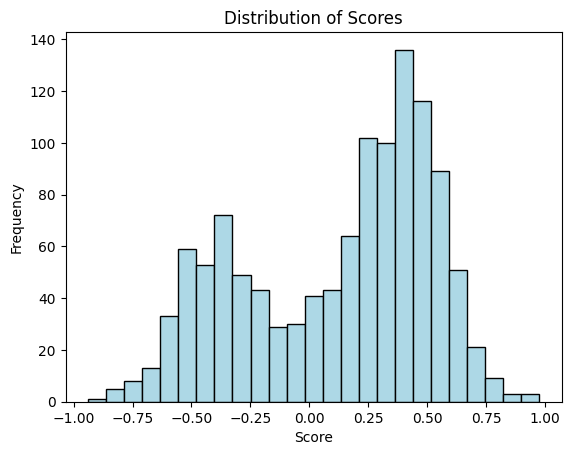

In [ ]:
#Plotting the distribution of "score" values
combined_df['score'].hist(bins=25, color="lightblue", edgecolor="black", grid = False)

#Adding labels and title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

#Display the plot
plt.show()

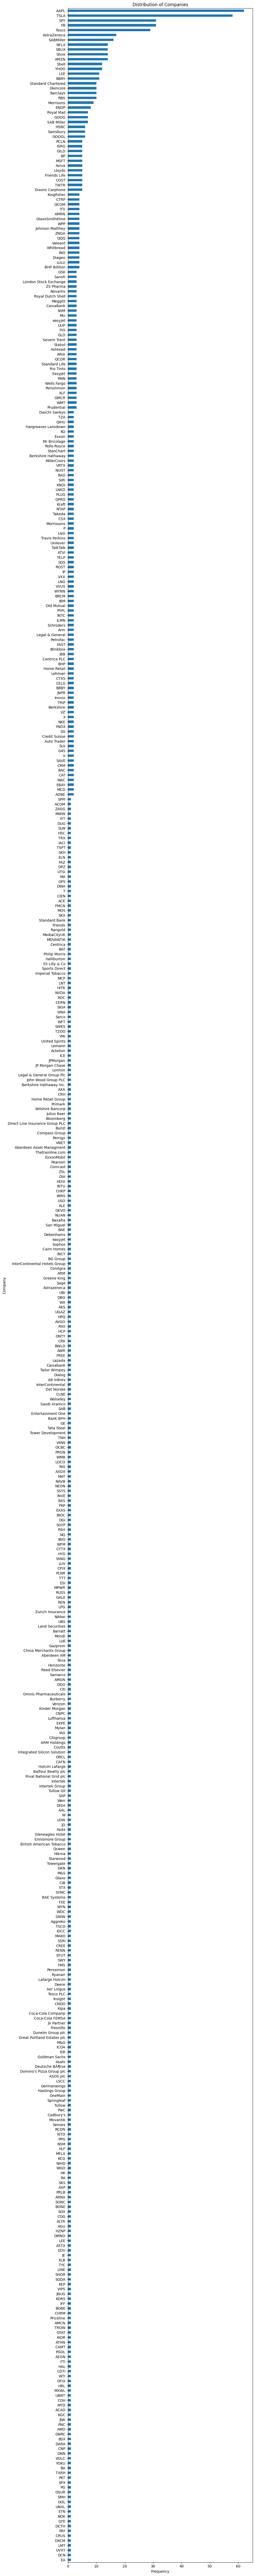

In [ ]:
#Plotting the distribution of "score" values
plt.figure(figsize=(10, 100))
combined_df['target'].value_counts().head(combined_df['target'].nunique()).sort_values().plot(kind='barh')

#Adding Labels
plt.xlabel('Frequency')
plt.ylabel("Company")
plt.title(f'Distribution of Companies')

#SHowing the plot
plt.tight_layout()
plt.show()

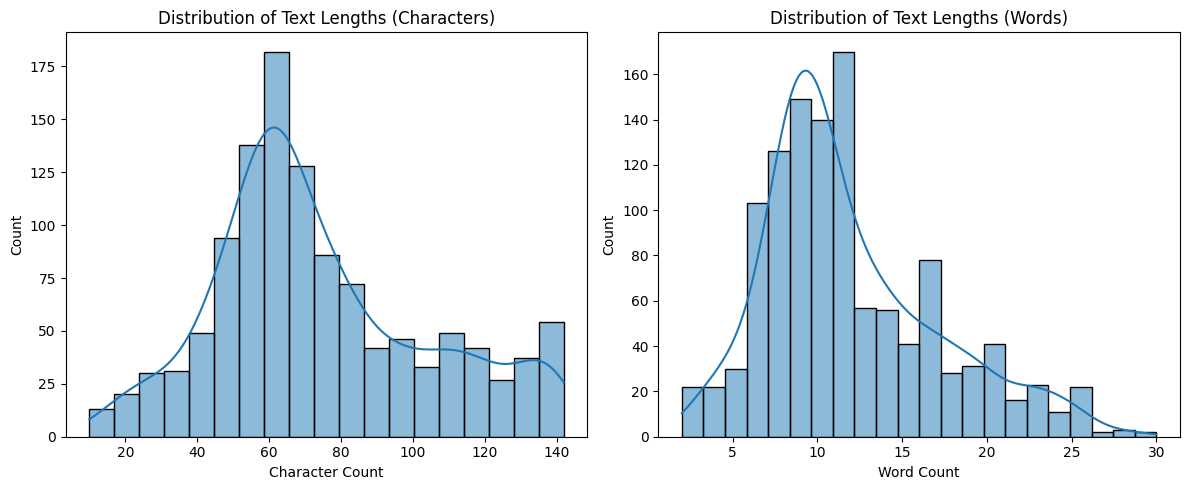

In [ ]:
# Add columns for text length analysis
combined_df['text_length'] = combined_df['sentence'].apply(len)
combined_df['word_count'] = combined_df['sentence'].apply(lambda x: len(str(x).split()))

# Plot distribution of text lengths
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(combined_df['text_length'], kde=True)
plt.title('Distribution of Text Lengths (Characters)')
plt.xlabel('Character Count')

plt.subplot(1, 2, 2)
sns.histplot(combined_df['word_count'], kde=True)
plt.title('Distribution of Text Lengths (Words)')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()

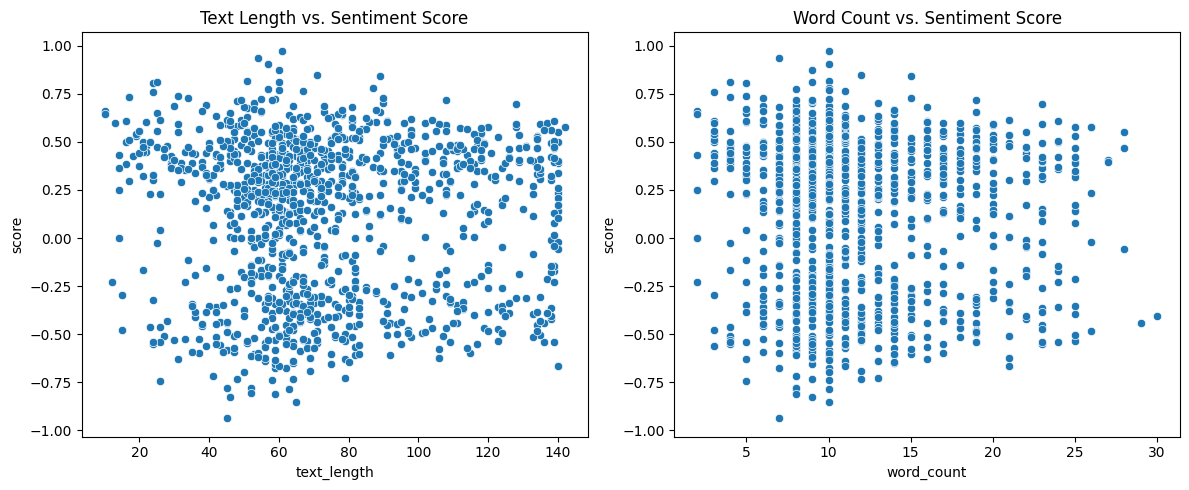

In [ ]:
#Examine if text length correlates with sentiment score
#Subplot for text_length vs. score
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='text_length', y='score', data=combined_df)
plt.title('Text Length vs. Sentiment Score')

#Subplot for word_count vs. score
plt.subplot(1, 2, 2)
sns.scatterplot(x='word_count', y='score', data=combined_df)
plt.title('Word Count vs. Sentiment Score')
plt.tight_layout()
plt.show()

## FinBERT + Regression Head
Here we use the pretrained FinBERT model and add a regression head to it in order to take the [CLS] embedding from FinBERT and ensure a single output.

In [16]:
#Model Architecture #1 for Regression: No Dropout and a 2 layer network
class FinBERTegressor(nn.Module):
  def __init__(self):
      super(FinBERTegressor, self).__init__()
      self.bert = AutoModel.from_pretrained("yiyanghkust/finbert-tone")

      #Define the regressor head
      self.regressor = nn.Sequential(
          nn.Linear(768, 256),
          nn.ReLU(),
          nn.Linear(256, 1),
          nn.Tanh()
      )

  def forward(self, input_ids, attention_mask):
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      cls_output = bert_output.last_hidden_state[:, 0, :]  # Use CLS token
      return self.regressor(cls_output)

#Model Architecture #2 for Regression: W/ Dropout and a 3 layer network
class FinBERTRegressorB(nn.Module):
  def __init__(self):
      super(FinBERTRegressorB, self).__init__()
      self.bert = AutoModel.from_pretrained("yiyanghkust/finbert-tone")

      #Define the regressor head
      self.regressor = nn.Sequential(
          nn.Linear(768, 512),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(256, 1),
          nn.Tanh()
      )

  def forward(self, input_ids, attention_mask):
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      cls_output = bert_output.last_hidden_state[:, 0, :]  # Use CLS token
      return self.regressor(cls_output)

#Class to tokenize the data
class FinBERTDataset(Dataset):
  def __init__(self, sentences, scores, tokenizer, max_length):
    self.sentences = sentences
    self.scores = scores
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, idx):
    inputs = self.tokenizer(
        self.sentences[idx],
        padding='max_length',
        truncation=False,
        max_length=self.max_length,
        return_tensors='pt'
    )

    item = {key: val.squeeze(0) for key, val in inputs.items()}
    item['score'] = torch.tensor(self.scores[idx], dtype=torch.float32)

    return item

In [17]:
# Load the tokenizer for FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

In [ ]:
#Calculating Maximum token length
max_token_lengths = []

for sentence in combined_df['sentence']:
    # Tokenize without padding or truncation
    tokens = tokenizer(sentence, padding=False, truncation=False)
    max_token_lengths.append(len(tokens['input_ids']))

# Find the maximum length
max_length = max(max_token_lengths)

# Add a small buffer (optional) to account for special tokens like [CLS] and [SEP]
MAX_LENGTH = max_length + 6

print(f"Maximum token length in dataset: {max_length}")
print(f"Setting MAX_LENGTH to: {MAX_LENGTH}")

Maximum token length in dataset: 66
Setting MAX_LENGTH to: 72


### Training Function
Here we train the model using 10-fold cross-validation. First, 10-fold cross-validation provides a comprehensive assessment of model performance by partitioning the dataset into ten equally sized subsets. In each iteration, one subset is used as the validation set while the remaining nine are used for training. This process is repeated ten times, allowing every data point to serve as both a training and a validation instance exactly once. As a result, the evaluation metrics (e.g., MSE) are averaged over the ten folds, reducing variance and yielding a more stable estimate of the model's true predictive performance.

Second, financial text datasets used with FinBERT often suffer from issues such as limited size, class imbalance, and temporal distributional shifts. The use of 10-fold cross-validation helps mitigate the impact of these limitations by ensuring that the model is tested on diverse subsets of data. This is especially important in the context of sentiment-driven financial modeling, where overfitting to specific language patterns or news contexts can lead to poor generalization in real-world settings.

Finally, 10-fold cross-validation facilitates fair model comparison and hyperparameter tuning, as it allows consistent benchmarking across different configurations. This is critical when fine-tuning pre-trained transformers like FinBERT, where small changes in parameters can lead to significant differences in performance.

In [5]:
#Define Hyperparameters (came from Josh's grid search)
BATCH_SIZE = 64
LEARNING_RATE = 6.0702439706973085e-05
EPOCHS = 27
NUM_FOLDS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Function to train model for one epoch
def train_epoch(model, data_loader, optimizer, device):
  model.train()
  total_loss = 0

  progress_bar = tqdm(data_loader, desc="Training")
  for batch in progress_bar:

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scores = batch['score'].to(device)

        #Clear Gradients
        optimizer.zero_grad()

        #Forward Pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        #Calculate Loss (MSE)
        loss = torch.nn.MSELoss()(outputs.squeeze(), scores)

        #Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

  return total_loss / len(data_loader)

#Function to evaluate
def evaluate(model, data_loader, device):
  model.eval()
  predictions = []
  actual_values = []

  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      scores = batch['score'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      # Move tensors to CPU before converting to numpy
      predictions.extend(outputs.squeeze().cpu().numpy())
      actual_values.extend(scores.cpu().numpy())  # Add .cpu() here

  mse = mean_squared_error(actual_values, predictions)
  mae = mean_absolute_error(actual_values, predictions)

  return mse, mae, predictions, actual_values

#Main cross validation function
def run_k_fold_cross_validation(arch, df, k=10):
  #Prepare data
  sentences = combined_df['sentence'].tolist()
  scores = combined_df['score'].tolist()

  #Initialize K-fold cross validation
  kf = KFold(n_splits=k, shuffle=True, random_state=42)

  # Track metrics across folds
  fold_results = []
  all_predictions = []
  all_actuals = []

  # Loop through each fold
  for fold, (train_idx, val_idx) in enumerate(kf.split(sentences)):
      print(f"\n{'='*50}")
      print(f"Starting Fold {fold+1}/{k}")
      print(f"{'='*50}")

      # Split data for this fold
      train_sentences = [sentences[i] for i in train_idx]
      train_scores = [scores[i] for i in train_idx]
      val_sentences = [sentences[i] for i in val_idx]
      val_scores = [scores[i] for i in val_idx]

      # Create datasets
      train_dataset = FinBERTDataset(
          train_sentences, train_scores, tokenizer, MAX_LENGTH
      )
      val_dataset = FinBERTDataset(
          val_sentences, val_scores, tokenizer, MAX_LENGTH
      )

      # Create data loaders
      train_loader = DataLoader(
          train_dataset, batch_size=BATCH_SIZE, shuffle=True
      )
      val_loader = DataLoader(
          val_dataset, batch_size=BATCH_SIZE
      )

      # Initialize model and optimizer
      if arch == "FinBERTegressor":
        model = FinBERTegressor().to(DEVICE)
      elif arch == "FinBERTRegressorB":
        model = FinBERTRegressorB().to(DEVICE)
      optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

      # Training loop
      best_val_mse = float('inf')
      best_model_state = None

      for epoch in range(EPOCHS):
          # Train
          train_loss = train_epoch(model, train_loader, optimizer, DEVICE)

          # Evaluate
          val_mse, val_mae, _, _ = evaluate(model, val_loader, DEVICE)

          print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")

          # Save best model
          if val_mse < best_val_mse:
              best_val_mse = val_mse
              best_model_state = model.state_dict().copy()

      # Load best model and evaluate final performance
      model.load_state_dict(best_model_state)
      val_mse, val_mae, fold_preds, fold_actuals = evaluate(model, val_loader, DEVICE)

      # Store results
      fold_results.append({
          'fold': fold + 1,
          'mse': val_mse,
          'mae': val_mae
      })

      all_predictions.extend(fold_preds)
      all_actuals.extend(fold_actuals)

      # Optional: Save model for each fold
      #torch.save(model.state_dict(), f'finbert_regressor_fold_{fold+1}.pt')

      print(f"Fold {fold+1} Results - MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")

  # Print overall results
  results_df = pd.DataFrame(fold_results)
  print(f"\n{'='*50}")
  print("Cross-Validation Results:")
  print(f"Average MSE: {results_df['mse'].mean():.4f} ± {results_df['mse'].std():.4f}")
  print(f"Average MAE: {results_df['mae'].mean():.4f} ± {results_df['mae'].std():.4f}")

  # Visualize predictions vs actual
  plt.figure(figsize=(10, 6))
  plt.scatter(all_actuals, all_predictions, alpha=0.5)
  plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect prediction line
  plt.xlabel('Actual Scores')
  plt.ylabel('Predicted Scores')
  plt.title('Predicted vs Actual Scores (All Folds)')
  plt.grid(True, alpha=0.3)
  plt.savefig('prediction_vs_actual.png')
  plt.show()

  return results_df, all_predictions, all_actuals


## Training the different model architectures

*   FinBERTRegressor 2 layers with a tanh activation function and no dropout.
*   FINBERTRegressorB is a deeper NN with drouput.

Later, we also experiment with less number of folds as we use k-fold cross validation in the training process.


Starting Fold 1/10


Training: 100%|██████████| 66/66 [00:13<00:00,  4.81it/s, loss=0.0834]


Epoch 1/10 - Train Loss: 0.0939, Val MSE: 0.0626, Val MAE: 0.1865


Training: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s, loss=0.0400]


Epoch 2/10 - Train Loss: 0.0430, Val MSE: 0.0666, Val MAE: 0.1866


Training: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s, loss=0.0176]


Epoch 3/10 - Train Loss: 0.0254, Val MSE: 0.0611, Val MAE: 0.1799


Training: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.0129]


Epoch 4/10 - Train Loss: 0.0202, Val MSE: 0.0678, Val MAE: 0.1921


Training: 100%|██████████| 66/66 [00:14<00:00,  4.65it/s, loss=0.0097]


Epoch 5/10 - Train Loss: 0.0148, Val MSE: 0.0563, Val MAE: 0.1721


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0139]


Epoch 6/10 - Train Loss: 0.0123, Val MSE: 0.0562, Val MAE: 0.1750


Training: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s, loss=0.0073]


Epoch 7/10 - Train Loss: 0.0116, Val MSE: 0.0559, Val MAE: 0.1721


Training: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s, loss=0.0091]


Epoch 8/10 - Train Loss: 0.0099, Val MSE: 0.0587, Val MAE: 0.1749


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0241]


Epoch 9/10 - Train Loss: 0.0101, Val MSE: 0.0577, Val MAE: 0.1695


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0935]


Epoch 10/10 - Train Loss: 0.0096, Val MSE: 0.0553, Val MAE: 0.1675
Fold 1 Results - MSE: 0.0553, MAE: 0.1675

Starting Fold 2/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0659]


Epoch 1/10 - Train Loss: 0.1065, Val MSE: 0.0801, Val MAE: 0.2011


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0132]


Epoch 2/10 - Train Loss: 0.0453, Val MSE: 0.0709, Val MAE: 0.1850


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0424]


Epoch 3/10 - Train Loss: 0.0271, Val MSE: 0.0736, Val MAE: 0.1923


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0167]


Epoch 4/10 - Train Loss: 0.0157, Val MSE: 0.0769, Val MAE: 0.1905


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0132]


Epoch 5/10 - Train Loss: 0.0127, Val MSE: 0.0719, Val MAE: 0.1846


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0117]


Epoch 6/10 - Train Loss: 0.0119, Val MSE: 0.0726, Val MAE: 0.1874


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0035]


Epoch 7/10 - Train Loss: 0.0100, Val MSE: 0.0727, Val MAE: 0.1868


Training: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.0070]


Epoch 8/10 - Train Loss: 0.0098, Val MSE: 0.0693, Val MAE: 0.1885


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0066]


Epoch 9/10 - Train Loss: 0.0085, Val MSE: 0.0702, Val MAE: 0.1823


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0219]


Epoch 10/10 - Train Loss: 0.0083, Val MSE: 0.0698, Val MAE: 0.1820
Fold 2 Results - MSE: 0.0698, MAE: 0.1820

Starting Fold 3/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.1187]


Epoch 1/10 - Train Loss: 0.0998, Val MSE: 0.0820, Val MAE: 0.2152


Training: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s, loss=0.0188]


Epoch 2/10 - Train Loss: 0.0472, Val MSE: 0.0726, Val MAE: 0.1882


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0331]


Epoch 3/10 - Train Loss: 0.0270, Val MSE: 0.0701, Val MAE: 0.1833


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0209]


Epoch 4/10 - Train Loss: 0.0186, Val MSE: 0.0710, Val MAE: 0.1860


Training: 100%|██████████| 66/66 [00:14<00:00,  4.53it/s, loss=0.0215]


Epoch 5/10 - Train Loss: 0.0149, Val MSE: 0.0667, Val MAE: 0.1782


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0282]


Epoch 6/10 - Train Loss: 0.0123, Val MSE: 0.0692, Val MAE: 0.1850


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0058]


Epoch 7/10 - Train Loss: 0.0111, Val MSE: 0.0660, Val MAE: 0.1842


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0087]


Epoch 8/10 - Train Loss: 0.0104, Val MSE: 0.0680, Val MAE: 0.1792


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0101]


Epoch 9/10 - Train Loss: 0.0096, Val MSE: 0.0658, Val MAE: 0.1763


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0066]


Epoch 10/10 - Train Loss: 0.0092, Val MSE: 0.0654, Val MAE: 0.1790
Fold 3 Results - MSE: 0.0654, MAE: 0.1790

Starting Fold 4/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.1006]


Epoch 1/10 - Train Loss: 0.0939, Val MSE: 0.0669, Val MAE: 0.1896


Training: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s, loss=0.0599]


Epoch 2/10 - Train Loss: 0.0437, Val MSE: 0.0667, Val MAE: 0.1870


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0099]


Epoch 3/10 - Train Loss: 0.0255, Val MSE: 0.0751, Val MAE: 0.1979


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0232]


Epoch 4/10 - Train Loss: 0.0196, Val MSE: 0.0745, Val MAE: 0.1989


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0136]


Epoch 5/10 - Train Loss: 0.0143, Val MSE: 0.0716, Val MAE: 0.1890


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0435]


Epoch 6/10 - Train Loss: 0.0126, Val MSE: 0.0672, Val MAE: 0.1760


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0054]


Epoch 7/10 - Train Loss: 0.0122, Val MSE: 0.0630, Val MAE: 0.1734


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0166]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0683, Val MAE: 0.1831


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0181]


Epoch 9/10 - Train Loss: 0.0112, Val MSE: 0.0623, Val MAE: 0.1707


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0040]


Epoch 10/10 - Train Loss: 0.0091, Val MSE: 0.0641, Val MAE: 0.1783
Fold 4 Results - MSE: 0.0641, MAE: 0.1783

Starting Fold 5/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0716]


Epoch 1/10 - Train Loss: 0.1039, Val MSE: 0.0575, Val MAE: 0.1819


Training: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.0433]


Epoch 2/10 - Train Loss: 0.0518, Val MSE: 0.0541, Val MAE: 0.1808


Training: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s, loss=0.0211]


Epoch 3/10 - Train Loss: 0.0303, Val MSE: 0.0445, Val MAE: 0.1642


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0236]


Epoch 4/10 - Train Loss: 0.0200, Val MSE: 0.0394, Val MAE: 0.1511


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0307]


Epoch 5/10 - Train Loss: 0.0148, Val MSE: 0.0401, Val MAE: 0.1541


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0162]


Epoch 6/10 - Train Loss: 0.0141, Val MSE: 0.0401, Val MAE: 0.1551


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0060]


Epoch 7/10 - Train Loss: 0.0116, Val MSE: 0.0383, Val MAE: 0.1498


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0138]


Epoch 8/10 - Train Loss: 0.0103, Val MSE: 0.0420, Val MAE: 0.1571


Training: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s, loss=0.0114]


Epoch 9/10 - Train Loss: 0.0106, Val MSE: 0.0386, Val MAE: 0.1483


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0052]


Epoch 10/10 - Train Loss: 0.0085, Val MSE: 0.0429, Val MAE: 0.1603
Fold 5 Results - MSE: 0.0429, MAE: 0.1603

Starting Fold 6/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.1126]


Epoch 1/10 - Train Loss: 0.1003, Val MSE: 0.0807, Val MAE: 0.2086


Training: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s, loss=0.0195]


Epoch 2/10 - Train Loss: 0.0417, Val MSE: 0.0699, Val MAE: 0.1899


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0295]


Epoch 3/10 - Train Loss: 0.0242, Val MSE: 0.0754, Val MAE: 0.1976


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0176]


Epoch 4/10 - Train Loss: 0.0166, Val MSE: 0.0721, Val MAE: 0.1918


Training: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.0134]


Epoch 5/10 - Train Loss: 0.0146, Val MSE: 0.0701, Val MAE: 0.1884


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0072]


Epoch 6/10 - Train Loss: 0.0110, Val MSE: 0.0721, Val MAE: 0.1878


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0090]


Epoch 7/10 - Train Loss: 0.0100, Val MSE: 0.0686, Val MAE: 0.1834


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0098]


Epoch 8/10 - Train Loss: 0.0090, Val MSE: 0.0660, Val MAE: 0.1836


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0065]


Epoch 9/10 - Train Loss: 0.0089, Val MSE: 0.0656, Val MAE: 0.1818


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0116]


Epoch 10/10 - Train Loss: 0.0083, Val MSE: 0.0648, Val MAE: 0.1785
Fold 6 Results - MSE: 0.0648, MAE: 0.1785

Starting Fold 7/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0293]


Epoch 1/10 - Train Loss: 0.1023, Val MSE: 0.1109, Val MAE: 0.2351


Training: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.0518]


Epoch 2/10 - Train Loss: 0.0438, Val MSE: 0.0906, Val MAE: 0.2107


Training: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.0267]


Epoch 3/10 - Train Loss: 0.0254, Val MSE: 0.0983, Val MAE: 0.2149


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0167]


Epoch 4/10 - Train Loss: 0.0180, Val MSE: 0.0957, Val MAE: 0.2123


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0153]


Epoch 5/10 - Train Loss: 0.0152, Val MSE: 0.0980, Val MAE: 0.2126


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0144]


Epoch 6/10 - Train Loss: 0.0140, Val MSE: 0.0953, Val MAE: 0.2106


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0055]


Epoch 7/10 - Train Loss: 0.0118, Val MSE: 0.0948, Val MAE: 0.2134


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0091]


Epoch 8/10 - Train Loss: 0.0111, Val MSE: 0.0956, Val MAE: 0.2082


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0161]


Epoch 9/10 - Train Loss: 0.0100, Val MSE: 0.0983, Val MAE: 0.2178


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0068]


Epoch 10/10 - Train Loss: 0.0098, Val MSE: 0.0959, Val MAE: 0.2153
Fold 7 Results - MSE: 0.0959, MAE: 0.2153

Starting Fold 8/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.1095]


Epoch 1/10 - Train Loss: 0.1047, Val MSE: 0.0551, Val MAE: 0.1815


Training: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.0127]


Epoch 2/10 - Train Loss: 0.0484, Val MSE: 0.0650, Val MAE: 0.1832


Training: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s, loss=0.0123]


Epoch 3/10 - Train Loss: 0.0277, Val MSE: 0.0681, Val MAE: 0.1854


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0129]


Epoch 4/10 - Train Loss: 0.0192, Val MSE: 0.0494, Val MAE: 0.1582


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0621]


Epoch 5/10 - Train Loss: 0.0137, Val MSE: 0.0609, Val MAE: 0.1763


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0099]


Epoch 6/10 - Train Loss: 0.0129, Val MSE: 0.0572, Val MAE: 0.1681


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0076]


Epoch 7/10 - Train Loss: 0.0117, Val MSE: 0.0592, Val MAE: 0.1714


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0055]


Epoch 8/10 - Train Loss: 0.0101, Val MSE: 0.0568, Val MAE: 0.1691


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0096]


Epoch 9/10 - Train Loss: 0.0092, Val MSE: 0.0547, Val MAE: 0.1637


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0067]


Epoch 10/10 - Train Loss: 0.0091, Val MSE: 0.0535, Val MAE: 0.1631
Fold 8 Results - MSE: 0.0535, MAE: 0.1631

Starting Fold 9/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0295]


Epoch 1/10 - Train Loss: 0.1028, Val MSE: 0.0876, Val MAE: 0.2088


Training: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s, loss=0.0625]


Epoch 2/10 - Train Loss: 0.0432, Val MSE: 0.0790, Val MAE: 0.1949


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0235]


Epoch 3/10 - Train Loss: 0.0264, Val MSE: 0.0769, Val MAE: 0.1923


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0066]


Epoch 4/10 - Train Loss: 0.0169, Val MSE: 0.0730, Val MAE: 0.1823


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0053]


Epoch 5/10 - Train Loss: 0.0130, Val MSE: 0.0682, Val MAE: 0.1761


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0140]


Epoch 6/10 - Train Loss: 0.0116, Val MSE: 0.0740, Val MAE: 0.1824


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0028]


Epoch 7/10 - Train Loss: 0.0096, Val MSE: 0.0734, Val MAE: 0.1820


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0082]


Epoch 8/10 - Train Loss: 0.0097, Val MSE: 0.0765, Val MAE: 0.1824


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0058]


Epoch 9/10 - Train Loss: 0.0080, Val MSE: 0.0756, Val MAE: 0.1815


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0116]


Epoch 10/10 - Train Loss: 0.0090, Val MSE: 0.0708, Val MAE: 0.1763
Fold 9 Results - MSE: 0.0708, MAE: 0.1763

Starting Fold 10/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0809]


Epoch 1/10 - Train Loss: 0.1154, Val MSE: 0.0812, Val MAE: 0.2089


Training: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s, loss=0.0299]


Epoch 2/10 - Train Loss: 0.0516, Val MSE: 0.0660, Val MAE: 0.1919


Training: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.0446]


Epoch 3/10 - Train Loss: 0.0292, Val MSE: 0.0683, Val MAE: 0.1849


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0306]


Epoch 4/10 - Train Loss: 0.0190, Val MSE: 0.0650, Val MAE: 0.1841


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0090]


Epoch 5/10 - Train Loss: 0.0136, Val MSE: 0.0609, Val MAE: 0.1770


Training: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.0171]


Epoch 6/10 - Train Loss: 0.0109, Val MSE: 0.0655, Val MAE: 0.1848


Training: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.0373]


Epoch 7/10 - Train Loss: 0.0106, Val MSE: 0.0644, Val MAE: 0.1820


Training: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s, loss=0.0115]


Epoch 8/10 - Train Loss: 0.0106, Val MSE: 0.0626, Val MAE: 0.1814


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0072]


Epoch 9/10 - Train Loss: 0.0103, Val MSE: 0.0598, Val MAE: 0.1758


Training: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.0087]


Epoch 10/10 - Train Loss: 0.0083, Val MSE: 0.0581, Val MAE: 0.1757
Fold 10 Results - MSE: 0.0581, MAE: 0.1757

Cross-Validation Results:
Average MSE: 0.0641 ± 0.0140
Average MAE: 0.1776 ± 0.0151


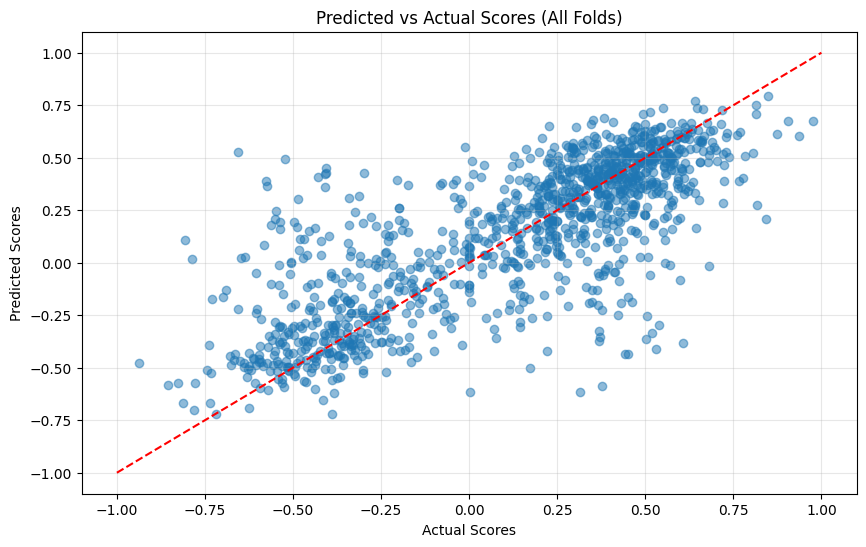

In [ ]:
# Run cross-validation (assuming combined_df is your dataframe)
results, predictions, actuals = run_k_fold_cross_validation(combined_df, k=NUM_FOLDS)


Starting Fold 1/10


Training: 100%|██████████| 66/66 [00:13<00:00,  4.85it/s, loss=0.0350]


Epoch 1/10 - Train Loss: 0.0971, Val MSE: 0.0637, Val MAE: 0.1868


Training: 100%|██████████| 66/66 [00:13<00:00,  4.79it/s, loss=0.0584]


Epoch 2/10 - Train Loss: 0.0501, Val MSE: 0.0715, Val MAE: 0.1913


Training: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=0.0428]


Epoch 3/10 - Train Loss: 0.0283, Val MSE: 0.0622, Val MAE: 0.1778


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0145]


Epoch 4/10 - Train Loss: 0.0201, Val MSE: 0.0602, Val MAE: 0.1707


Training: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s, loss=0.0153]


Epoch 5/10 - Train Loss: 0.0160, Val MSE: 0.0574, Val MAE: 0.1648


Training: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.0045]


Epoch 6/10 - Train Loss: 0.0144, Val MSE: 0.0541, Val MAE: 0.1676


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0099]


Epoch 7/10 - Train Loss: 0.0118, Val MSE: 0.0590, Val MAE: 0.1742


Training: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s, loss=0.0186]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0572, Val MAE: 0.1770


Training: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.0055]


Epoch 9/10 - Train Loss: 0.0096, Val MSE: 0.0593, Val MAE: 0.1776


Training: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.0065]


Epoch 10/10 - Train Loss: 0.0087, Val MSE: 0.0520, Val MAE: 0.1578
Fold 1 Results - MSE: 0.0520, MAE: 0.1578

Starting Fold 2/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s, loss=0.0330]


Epoch 1/10 - Train Loss: 0.1001, Val MSE: 0.0729, Val MAE: 0.2028


Training: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.0723]


Epoch 2/10 - Train Loss: 0.0526, Val MSE: 0.0716, Val MAE: 0.1945


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0101]


Epoch 3/10 - Train Loss: 0.0309, Val MSE: 0.0730, Val MAE: 0.1891


Training: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.0185]


Epoch 4/10 - Train Loss: 0.0222, Val MSE: 0.0784, Val MAE: 0.1953


Training: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.0169]


Epoch 5/10 - Train Loss: 0.0167, Val MSE: 0.0776, Val MAE: 0.1972


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0178]


Epoch 6/10 - Train Loss: 0.0156, Val MSE: 0.0752, Val MAE: 0.1921


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0078]


Epoch 7/10 - Train Loss: 0.0123, Val MSE: 0.0764, Val MAE: 0.1953


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0096]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0742, Val MAE: 0.1876


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0071]


Epoch 9/10 - Train Loss: 0.0093, Val MSE: 0.0686, Val MAE: 0.1845


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0045]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0686, Val MAE: 0.1840
Fold 2 Results - MSE: 0.0686, MAE: 0.1840

Starting Fold 3/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.1045]


Epoch 1/10 - Train Loss: 0.0941, Val MSE: 0.0747, Val MAE: 0.2018


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0295]


Epoch 2/10 - Train Loss: 0.0477, Val MSE: 0.0773, Val MAE: 0.1999


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0320]


Epoch 3/10 - Train Loss: 0.0293, Val MSE: 0.0771, Val MAE: 0.1960


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0260]


Epoch 4/10 - Train Loss: 0.0234, Val MSE: 0.0803, Val MAE: 0.1919


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0219]


Epoch 5/10 - Train Loss: 0.0166, Val MSE: 0.0768, Val MAE: 0.1874


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0199]


Epoch 6/10 - Train Loss: 0.0148, Val MSE: 0.0744, Val MAE: 0.1852


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0060]


Epoch 7/10 - Train Loss: 0.0116, Val MSE: 0.0727, Val MAE: 0.1870


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0164]


Epoch 8/10 - Train Loss: 0.0119, Val MSE: 0.0662, Val MAE: 0.1830


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0092]


Epoch 9/10 - Train Loss: 0.0098, Val MSE: 0.0671, Val MAE: 0.1804


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0060]


Epoch 10/10 - Train Loss: 0.0093, Val MSE: 0.0690, Val MAE: 0.1831
Fold 3 Results - MSE: 0.0690, MAE: 0.1831

Starting Fold 4/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0920]


Epoch 1/10 - Train Loss: 0.0999, Val MSE: 0.0760, Val MAE: 0.2034


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0470]


Epoch 2/10 - Train Loss: 0.0515, Val MSE: 0.0639, Val MAE: 0.1912


Training: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.0251]


Epoch 3/10 - Train Loss: 0.0310, Val MSE: 0.0729, Val MAE: 0.1920


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0232]


Epoch 4/10 - Train Loss: 0.0197, Val MSE: 0.0804, Val MAE: 0.2026


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0512]


Epoch 5/10 - Train Loss: 0.0153, Val MSE: 0.0656, Val MAE: 0.1786


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0080]


Epoch 6/10 - Train Loss: 0.0124, Val MSE: 0.0707, Val MAE: 0.1814


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0113]


Epoch 7/10 - Train Loss: 0.0119, Val MSE: 0.0731, Val MAE: 0.1867


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0062]


Epoch 8/10 - Train Loss: 0.0114, Val MSE: 0.0754, Val MAE: 0.1914


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0117]


Epoch 9/10 - Train Loss: 0.0100, Val MSE: 0.0706, Val MAE: 0.1904


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0032]


Epoch 10/10 - Train Loss: 0.0090, Val MSE: 0.0694, Val MAE: 0.1846
Fold 4 Results - MSE: 0.0694, MAE: 0.1846

Starting Fold 5/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0514]


Epoch 1/10 - Train Loss: 0.1012, Val MSE: 0.0484, Val MAE: 0.1702


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0640]


Epoch 2/10 - Train Loss: 0.0509, Val MSE: 0.0423, Val MAE: 0.1610


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0183]


Epoch 3/10 - Train Loss: 0.0322, Val MSE: 0.0447, Val MAE: 0.1582


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0097]


Epoch 4/10 - Train Loss: 0.0218, Val MSE: 0.0446, Val MAE: 0.1597


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0137]


Epoch 5/10 - Train Loss: 0.0168, Val MSE: 0.0405, Val MAE: 0.1521


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0045]


Epoch 6/10 - Train Loss: 0.0145, Val MSE: 0.0433, Val MAE: 0.1610


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0051]


Epoch 7/10 - Train Loss: 0.0126, Val MSE: 0.0425, Val MAE: 0.1573


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0106]


Epoch 8/10 - Train Loss: 0.0107, Val MSE: 0.0391, Val MAE: 0.1546


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0611]


Epoch 9/10 - Train Loss: 0.0102, Val MSE: 0.0411, Val MAE: 0.1522


Training: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.0047]


Epoch 10/10 - Train Loss: 0.0082, Val MSE: 0.0414, Val MAE: 0.1553
Fold 5 Results - MSE: 0.0414, MAE: 0.1553

Starting Fold 6/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0788]


Epoch 1/10 - Train Loss: 0.0909, Val MSE: 0.0718, Val MAE: 0.2012


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.1155]


Epoch 2/10 - Train Loss: 0.0478, Val MSE: 0.0671, Val MAE: 0.1765


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0195]


Epoch 3/10 - Train Loss: 0.0299, Val MSE: 0.0662, Val MAE: 0.1771


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0103]


Epoch 4/10 - Train Loss: 0.0205, Val MSE: 0.0612, Val MAE: 0.1715


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0114]


Epoch 5/10 - Train Loss: 0.0154, Val MSE: 0.0667, Val MAE: 0.1800


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0087]


Epoch 6/10 - Train Loss: 0.0135, Val MSE: 0.0685, Val MAE: 0.1753


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0102]


Epoch 7/10 - Train Loss: 0.0121, Val MSE: 0.0591, Val MAE: 0.1659


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0086]


Epoch 8/10 - Train Loss: 0.0113, Val MSE: 0.0597, Val MAE: 0.1680


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0070]


Epoch 9/10 - Train Loss: 0.0089, Val MSE: 0.0652, Val MAE: 0.1792


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0136]


Epoch 10/10 - Train Loss: 0.0079, Val MSE: 0.0603, Val MAE: 0.1688
Fold 6 Results - MSE: 0.0603, MAE: 0.1688

Starting Fold 7/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0726]


Epoch 1/10 - Train Loss: 0.0938, Val MSE: 0.1027, Val MAE: 0.2208


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0762]


Epoch 2/10 - Train Loss: 0.0475, Val MSE: 0.0997, Val MAE: 0.2208


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0184]


Epoch 3/10 - Train Loss: 0.0310, Val MSE: 0.0991, Val MAE: 0.2138


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0113]


Epoch 4/10 - Train Loss: 0.0222, Val MSE: 0.0902, Val MAE: 0.1988


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0152]


Epoch 5/10 - Train Loss: 0.0186, Val MSE: 0.0847, Val MAE: 0.1973


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0155]


Epoch 6/10 - Train Loss: 0.0145, Val MSE: 0.0913, Val MAE: 0.2062


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0171]


Epoch 7/10 - Train Loss: 0.0115, Val MSE: 0.0973, Val MAE: 0.2176


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0129]


Epoch 8/10 - Train Loss: 0.0108, Val MSE: 0.0957, Val MAE: 0.2139


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0164]


Epoch 9/10 - Train Loss: 0.0106, Val MSE: 0.0886, Val MAE: 0.2028


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0076]


Epoch 10/10 - Train Loss: 0.0098, Val MSE: 0.0940, Val MAE: 0.2123
Fold 7 Results - MSE: 0.0940, MAE: 0.2123

Starting Fold 8/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0427]


Epoch 1/10 - Train Loss: 0.0964, Val MSE: 0.0614, Val MAE: 0.1794


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0515]


Epoch 2/10 - Train Loss: 0.0489, Val MSE: 0.0672, Val MAE: 0.1855


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0278]


Epoch 3/10 - Train Loss: 0.0298, Val MSE: 0.0582, Val MAE: 0.1717


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0120]


Epoch 4/10 - Train Loss: 0.0203, Val MSE: 0.0597, Val MAE: 0.1697


Training: 100%|██████████| 66/66 [00:14<00:00,  4.53it/s, loss=0.0206]


Epoch 5/10 - Train Loss: 0.0164, Val MSE: 0.0614, Val MAE: 0.1717


Training: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s, loss=0.0092]


Epoch 6/10 - Train Loss: 0.0153, Val MSE: 0.0535, Val MAE: 0.1587


Training: 100%|██████████| 66/66 [00:14<00:00,  4.55it/s, loss=0.0143]


Epoch 7/10 - Train Loss: 0.0122, Val MSE: 0.0592, Val MAE: 0.1690


Training: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.0154]


Epoch 8/10 - Train Loss: 0.0119, Val MSE: 0.0582, Val MAE: 0.1691


Training: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s, loss=0.0094]


Epoch 9/10 - Train Loss: 0.0116, Val MSE: 0.0542, Val MAE: 0.1596


Training: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.0127]


Epoch 10/10 - Train Loss: 0.0099, Val MSE: 0.0536, Val MAE: 0.1632
Fold 8 Results - MSE: 0.0536, MAE: 0.1632

Starting Fold 9/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.0541]


Epoch 1/10 - Train Loss: 0.0918, Val MSE: 0.0892, Val MAE: 0.2222


Training: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.0618]


Epoch 2/10 - Train Loss: 0.0488, Val MSE: 0.0747, Val MAE: 0.1861


Training: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s, loss=0.0344]


Epoch 3/10 - Train Loss: 0.0276, Val MSE: 0.0678, Val MAE: 0.1790


Training: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.0246]


Epoch 4/10 - Train Loss: 0.0196, Val MSE: 0.0743, Val MAE: 0.1885


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0056]


Epoch 5/10 - Train Loss: 0.0152, Val MSE: 0.0759, Val MAE: 0.1831


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0138]


Epoch 6/10 - Train Loss: 0.0138, Val MSE: 0.0754, Val MAE: 0.1854


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0114]


Epoch 7/10 - Train Loss: 0.0122, Val MSE: 0.0759, Val MAE: 0.1798


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0153]


Epoch 8/10 - Train Loss: 0.0113, Val MSE: 0.0752, Val MAE: 0.1879


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0085]


Epoch 9/10 - Train Loss: 0.0102, Val MSE: 0.0678, Val MAE: 0.1761


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0045]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0740, Val MAE: 0.1789
Fold 9 Results - MSE: 0.0740, MAE: 0.1789

Starting Fold 10/10


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0751]


Epoch 1/10 - Train Loss: 0.0976, Val MSE: 0.0756, Val MAE: 0.1893


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0362]


Epoch 2/10 - Train Loss: 0.0479, Val MSE: 0.0672, Val MAE: 0.1917


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0331]


Epoch 3/10 - Train Loss: 0.0298, Val MSE: 0.0587, Val MAE: 0.1661


Training: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.0094]


Epoch 4/10 - Train Loss: 0.0203, Val MSE: 0.0616, Val MAE: 0.1733


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0146]


Epoch 5/10 - Train Loss: 0.0154, Val MSE: 0.0574, Val MAE: 0.1691


Training: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.0077]


Epoch 6/10 - Train Loss: 0.0132, Val MSE: 0.0593, Val MAE: 0.1724


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0108]


Epoch 7/10 - Train Loss: 0.0112, Val MSE: 0.0588, Val MAE: 0.1746


Training: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.0119]


Epoch 8/10 - Train Loss: 0.0105, Val MSE: 0.0595, Val MAE: 0.1747


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0139]


Epoch 9/10 - Train Loss: 0.0096, Val MSE: 0.0606, Val MAE: 0.1743


Training: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.0057]


Epoch 10/10 - Train Loss: 0.0086, Val MSE: 0.0566, Val MAE: 0.1751
Fold 10 Results - MSE: 0.0566, MAE: 0.1751

Cross-Validation Results:
Average MSE: 0.0639 ± 0.0146
Average MAE: 0.1763 ± 0.0166


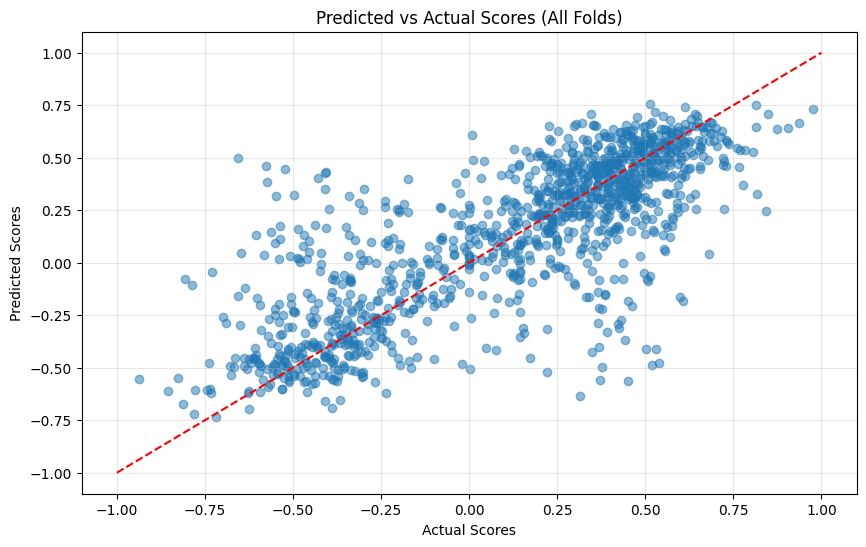

In [ ]:
#Training the alternate model architecture
results_b, predictions_b, actuals_b = run_k_fold_cross_validation("FinBERTRegressorB", combined_df, k=NUM_FOLDS)

## Training the final model
Using the final hyperparameters from the hyperparameter search we train the final model on the entire dataset.


Training Final Model on Entire Dataset


Training: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s, loss=0.0840]


Epoch 1/27 - Train Loss: 0.1466, Val MSE: 0.0868, Val MAE: 0.2378


Training: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s, loss=0.0628]


Epoch 2/27 - Train Loss: 0.0638, Val MSE: 0.0763, Val MAE: 0.2076


Training: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s, loss=0.0201]


Epoch 3/27 - Train Loss: 0.0332, Val MSE: 0.0712, Val MAE: 0.2099


Training: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s, loss=0.0160]


Epoch 4/27 - Train Loss: 0.0193, Val MSE: 0.0658, Val MAE: 0.1977


Training: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s, loss=0.0087]


Epoch 5/27 - Train Loss: 0.0125, Val MSE: 0.0698, Val MAE: 0.1976


Training: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s, loss=0.0088]


Epoch 6/27 - Train Loss: 0.0102, Val MSE: 0.0684, Val MAE: 0.1950


Training: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s, loss=0.0069]


Epoch 7/27 - Train Loss: 0.0088, Val MSE: 0.0711, Val MAE: 0.1986


Training: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s, loss=0.0089]


Epoch 8/27 - Train Loss: 0.0084, Val MSE: 0.0656, Val MAE: 0.1927


Training: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s, loss=0.0045]


Epoch 9/27 - Train Loss: 0.0074, Val MSE: 0.0604, Val MAE: 0.1889


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0124]


Epoch 10/27 - Train Loss: 0.0074, Val MSE: 0.0601, Val MAE: 0.1820


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0060]


Epoch 11/27 - Train Loss: 0.0069, Val MSE: 0.0670, Val MAE: 0.1913


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0065]


Epoch 12/27 - Train Loss: 0.0062, Val MSE: 0.0616, Val MAE: 0.1860


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0061]


Epoch 13/27 - Train Loss: 0.0060, Val MSE: 0.0617, Val MAE: 0.1904


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0187]


Epoch 14/27 - Train Loss: 0.0056, Val MSE: 0.0644, Val MAE: 0.1844


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0063]


Epoch 15/27 - Train Loss: 0.0056, Val MSE: 0.0632, Val MAE: 0.1874


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0024]


Epoch 16/27 - Train Loss: 0.0051, Val MSE: 0.0617, Val MAE: 0.1842


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0031]


Epoch 17/27 - Train Loss: 0.0051, Val MSE: 0.0622, Val MAE: 0.1878


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0032]


Epoch 18/27 - Train Loss: 0.0051, Val MSE: 0.0615, Val MAE: 0.1800


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0040]


Epoch 19/27 - Train Loss: 0.0051, Val MSE: 0.0614, Val MAE: 0.1806


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0102]


Epoch 20/27 - Train Loss: 0.0052, Val MSE: 0.0602, Val MAE: 0.1799


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0088]


Epoch 21/27 - Train Loss: 0.0051, Val MSE: 0.0634, Val MAE: 0.1831


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0029]


Epoch 22/27 - Train Loss: 0.0057, Val MSE: 0.0614, Val MAE: 0.1831


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0035]


Epoch 23/27 - Train Loss: 0.0050, Val MSE: 0.0641, Val MAE: 0.1864


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0040]


Epoch 24/27 - Train Loss: 0.0043, Val MSE: 0.0650, Val MAE: 0.1820


Training: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s, loss=0.0024]


Epoch 25/27 - Train Loss: 0.0048, Val MSE: 0.0618, Val MAE: 0.1794


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0028]


Epoch 26/27 - Train Loss: 0.0047, Val MSE: 0.0621, Val MAE: 0.1792


Training: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s, loss=0.0021]


Epoch 27/27 - Train Loss: 0.0044, Val MSE: 0.0635, Val MAE: 0.1819


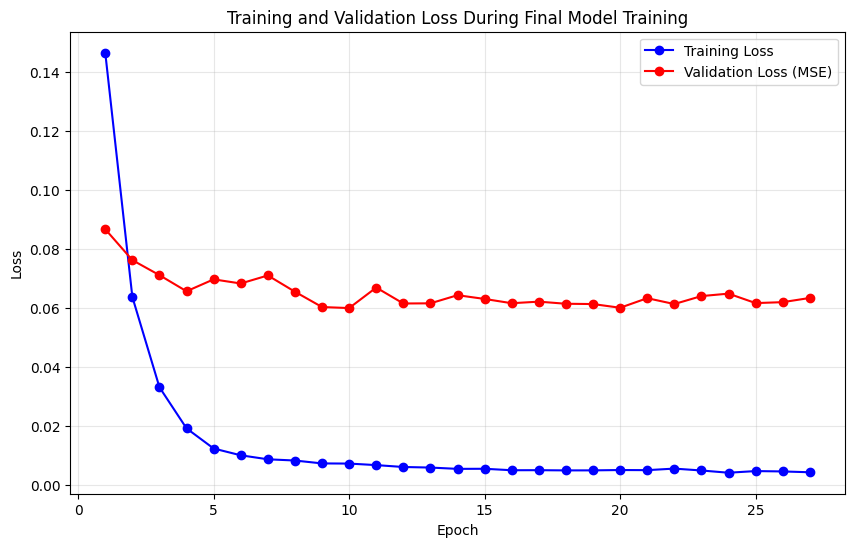


Evaluating on Holdout Set
Holdout MSE: 0.0548, Holdout MAE: 0.1677


In [ ]:
def train_final_model(df, validation_split=0.1, holdout_split=0.1):
    print(f"\n{'='*50}")
    print("Training Final Model on Entire Dataset")
    print(f"{'='*50}")

    # Split data into training and validation sets
    train_val_df, holdout_df = train_test_split(df, test_size=holdout_split, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=validation_split, random_state=42)

    # Prepare datasets
    train_dataset = FinBERTDataset(
        train_df['sentence'].tolist(),
        train_df['score'].tolist(),
        tokenizer,
        MAX_LENGTH
    )

    val_dataset = FinBERTDataset(
        val_df['sentence'].tolist(),
        val_df['score'].tolist(),
        tokenizer,
        MAX_LENGTH
    )

    holdout_dataset = FinBERTDataset(
        holdout_df['sentence'].tolist(),
        holdout_df['score'].tolist(),
        tokenizer,
        MAX_LENGTH
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    holdout_loader = DataLoader(holdout_dataset, batch_size=BATCH_SIZE)

    # Initialize model and optimizer
    model = FinBERTegressor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Train for all epochs
    for epoch in range(EPOCHS):
        # Train and record loss
        train_loss = train_epoch(model, train_loader, optimizer, DEVICE)
        train_losses.append(train_loss)

        # Evaluate on validation set
        val_mse, val_mae, _, _ = evaluate(model, val_loader, DEVICE)
        val_losses.append(val_mse)

        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    epochs = range(1, EPOCHS + 1)

    plt.plot(epochs, train_losses, 'b-', marker='o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', marker='o', label='Validation Loss (MSE)')

    plt.title('Training and Validation Loss During Final Model Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('final_model_loss_curves.png')
    plt.show()

    # Final evaluation on holdout set
    print(f"\n{'='*50}")
    print("Evaluating on Holdout Set")
    print(f"{'='*50}")
    holdout_mse, holdout_mae, _, _ = evaluate(model, holdout_loader, DEVICE)
    print(f"Holdout MSE: {holdout_mse:.4f}, Holdout MAE: {holdout_mae:.4f}")

    # Save the final model
    torch.save(model.state_dict(), 'finbert_regressor_final.pt')

    return model, train_losses, val_losses

final_model, train_losses, val_losses = train_final_model(combined_df)

## NewsAPI and yfinance Integration
Now we use the NewsAPI to gather headlines of data to see how accurate the FinBERT with model is on predicting if the stock will rise, fall or stay the same.
*   A rise is indicated by if the sentiment score goes up
*   A drop is indicated by if the sentiment score goes down
*   Stay-the-same is indicated by if the sentiment score stays relatively the same.




In [5]:
def get_recent_trading_days(ticker, days=14):
    # Set end date to yesterday
    end_date = datetime.now() - timedelta(days=1)
    # Get enough calendar days to ensure we have the requested trading days
    start_date = end_date - timedelta(days=days*2)

    # Download the data
    ticker_data = yf.download(ticker, start=start_date, end=end_date)

    # Get the specified number of trading days
    recent_data = ticker_data.tail(days)

    return recent_data

In [69]:
get_recent_trading_days('NVDA')

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2025-04-09,114.330002,115.099998,97.529999,98.889999,612918300
2025-04-10,107.570000,110.860001,99.150002,109.370003,437812400
2025-04-11,110.930000,111.550003,107.480003,108.500000,313417300
2025-04-14,110.709999,114.290001,109.070000,114.110001,264705000
2025-04-15,112.199997,113.620003,110.500000,110.970001,228966900
2025-04-16,104.489998,106.790001,100.449997,104.550003,397016900
2025-04-17,101.489998,104.470001,100.050003,104.449997,290833400
2025-04-21,96.910004,99.440002,95.040001,98.769997,288501100


In [91]:
def fetch_news_for_trading_days(api_key, queries, price_data):
    # Initialize NewsAPI client
    newsapi = NewsApiClient(api_key=api_key)

    # Get trading dates from price_data
    trading_dates = price_data.index.strftime('%Y-%m-%d').tolist()
    print(f"Fetching news for {len(trading_dates)} trading days from {min(trading_dates)} to {max(trading_dates)}")

    all_articles = []

    for query in queries:
        print(f"\nFetching news for query: '{query}'")
        for single_date in trading_dates:
            try:
                response = newsapi.get_everything(
                    q=query,
                    from_param=single_date,
                    to=single_date,
                    language="en",
                    sort_by="publishedAt",
                    page_size=100,
                    page=1  # Only 1 page allowed for free tier
                )

                articles = response.get('articles', [])
                if articles:
                    print(f"{single_date}: Found {len(articles)} articles for query '{query}'")
                    all_articles.extend(articles)

            except Exception as e:
                print(f"Error on {single_date} for query '{query}': {str(e)}")

    # Process and deduplicate articles
    results = []
    seen_urls = set()

    for article in all_articles:
        url = article.get('url')
        if url in seen_urls:
            continue
        seen_urls.add(url)

        published_date = article.get('publishedAt', '')
        headline = article.get('title', '')
        source = article.get('source', {}).get('name', '')

        if published_date:
            article_date = pd.to_datetime(published_date).strftime('%Y-%m-%d')
        else:
            article_date = ''

        results.append({
            'date': article_date,
            'headline': headline,
            'source': source,
            'url': url
        })

    # Create DataFrame
    news_df = pd.DataFrame(results)

    # Filter to include only trading dates
    if not news_df.empty:
        news_df = news_df[news_df['date'].isin(trading_dates)]
        news_df = news_df.sort_values('date', ascending=False)

    return news_df


def get_financial_data_and_news(ticker, queries, api_key, days=14):
    # Get financial data
    price_data = get_recent_trading_days(ticker, days)

    # Get news data specifically for the trading days
    news_data = fetch_news_for_trading_days(api_key, queries, price_data)

    return price_data, news_data

In [92]:
API_KEY = "c07a49b88bb14a60a889548af9185715"
queries = ["NVIDIA Corporation", "Nvidia stock", "NVDA"]
sp500_prices, sp500_news = get_financial_data_and_news('NVDA', queries, API_KEY, 20)

[*********************100%***********************]  1 of 1 completed


Fetching news for 20 trading days from 2025-04-01 to 2025-04-29

Fetching news for query: 'NVIDIA Corporation'
2025-04-01: Found 28 articles for query 'NVIDIA Corporation'
2025-04-02: Found 23 articles for query 'NVIDIA Corporation'
2025-04-03: Found 30 articles for query 'NVIDIA Corporation'
2025-04-04: Found 25 articles for query 'NVIDIA Corporation'
2025-04-07: Found 27 articles for query 'NVIDIA Corporation'
2025-04-08: Found 30 articles for query 'NVIDIA Corporation'
2025-04-09: Found 30 articles for query 'NVIDIA Corporation'
2025-04-10: Found 27 articles for query 'NVIDIA Corporation'
2025-04-11: Found 28 articles for query 'NVIDIA Corporation'
2025-04-14: Found 27 articles for query 'NVIDIA Corporation'
2025-04-15: Found 30 articles for query 'NVIDIA Corporation'
2025-04-16: Found 27 articles for query 'NVIDIA Corporation'
2025-04-17: Found 35 articles for query 'NVIDIA Corporation'
2025-04-21: Found 30 articles for query 'NVIDIA Corporation'
2025-04-22: Found 27 articles for q

In [128]:
min_value_col1 = sp500_news['date'].min()
print(min_value_col1)

2025-04-01


In [94]:
#Calculating Maximum token length
max_token_lengths = []

for sentence in sp500_news['headline']:
    # Tokenize without padding or truncation
    tokens = tokenizer(sentence, padding=False, truncation=False)
    max_token_lengths.append(len(tokens['input_ids']))

# Find the maximum length
max_length = max(max_token_lengths)

print(f"Maximum token length in dataset: {max_length}")

Maximum token length in dataset: 81


In [95]:
def analyze_sentiment(df, model_path=None):
    print("\nLoading FinBERT tokenizer and model...")

    # Load FinBERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

    # Initialize the model
    model = FinBERTegressor()

    # Load saved weights if provided
    if model_path:
        print(f"Loading model weights from {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        print("WARNING: No model weights provided. The model will give random outputs unless you've trained it.")

    # Set model to evaluation mode
    model.eval()

    # Make a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()

    # Add sentiment column
    result_df['sentiment_score'] = None
    result_df['sentiment_label'] = None

    print(f"Analyzing sentiment for {len(result_df)} headlines...")

    # Process headlines in batches to avoid memory issues
    batch_size = 16
    for i in range(0, len(result_df), batch_size):
        batch = result_df['headline'].iloc[i:i+batch_size].tolist()

        # Handle missing or NaN values in the batch
        batch = [str(text) if text is not None else '' for text in batch]

        # Tokenize inputs with fixed max_length parameter
        encoded_input = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt')

        # Get model predictions
        with torch.no_grad():
            input_ids = encoded_input['input_ids']
            attention_mask = encoded_input['attention_mask']
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Convert outputs to numpy for easier handling
        scores = outputs.squeeze().numpy()

        # Handle both single and batch outputs
        if scores.ndim == 0:
            scores = np.array([scores])

        # Update DataFrame with sentiment results
        for j, score in enumerate(scores):
            idx = i + j
            if idx >= len(result_df):
                break

            # Save the raw sentiment score (-1 to 1)
            sentiment_score = float(score)

            # Convert continuous score to categorical label
            if sentiment_score > 0.33:
                sentiment_label = 'positive'
            elif sentiment_score < -0.33:
                sentiment_label = 'negative'
            else:
                sentiment_label = 'neutral'

            # Update DataFrame
            result_df.iloc[idx, result_df.columns.get_loc('sentiment_score')] = sentiment_score
            result_df.iloc[idx, result_df.columns.get_loc('sentiment_label')] = sentiment_label

        # Print progress
        if i % (batch_size * 4) == 0 and i > 0:
            print(f"Processed {i}/{len(result_df)} headlines...")

    print("Sentiment analysis complete!")
    return result_df

In [96]:
sentiment_df = analyze_sentiment(sp500_news, "finbert_regressor_final.pt")


Loading FinBERT tokenizer and model...
Loading model weights from finbert_regressor_final.pt
Analyzing sentiment for 2477 headlines...
Processed 64/2477 headlines...
Processed 128/2477 headlines...
Processed 192/2477 headlines...
Processed 256/2477 headlines...
Processed 320/2477 headlines...
Processed 384/2477 headlines...
Processed 448/2477 headlines...
Processed 512/2477 headlines...
Processed 576/2477 headlines...
Processed 640/2477 headlines...
Processed 704/2477 headlines...
Processed 768/2477 headlines...
Processed 832/2477 headlines...
Processed 896/2477 headlines...
Processed 960/2477 headlines...
Processed 1024/2477 headlines...
Processed 1088/2477 headlines...
Processed 1152/2477 headlines...
Processed 1216/2477 headlines...
Processed 1280/2477 headlines...
Processed 1344/2477 headlines...
Processed 1408/2477 headlines...
Processed 1472/2477 headlines...
Processed 1536/2477 headlines...
Processed 1600/2477 headlines...
Processed 1664/2477 headlines...
Processed 1728/2477 he

In [112]:
c

,sentiment_score
date,
2025-04-01,0.078111
2025-04-02,0.040595
2025-04-03,-0.025186
2025-04-04,0.012507
2025-04-07,0.061058
2025-04-08,0.130786
2025-04-09,0.086504
2025-04-10,0.141861
2025-04-11,0.136059


In [105]:
sentiment_df_shifted = sentiment_df.copy()
sentiment_df_shifted['date'] = pd.to_datetime(sentiment_df_shifted['date']) + pd.Timedelta(days=1)
sentiment_df_shifted.head(50)

,date,headline,source,url,sentiment_score,sentiment_label
2476,2025-04-30,Pay Close Attention to This Crucial Revenue So...,Biztoc.com,https://biztoc.com/x/0f7d480901f82a2f,0.204903,neutral
2227,2025-04-30,Rheinmetall Shares Rise on Strong Preliminary ...,Biztoc.com,https://biztoc.com/x/5f3266bb0243e98b,0.7434,positive
2240,2025-04-30,China Life Profit Rises as Investment Returns ...,Biztoc.com,https://biztoc.com/x/0a9504f258aa9892,0.383606,positive
2239,2025-04-30,Cnooc Profit Drops as Lower Oil Prices Outweig...,Biztoc.com,https://biztoc.com/x/8a2ec40f55b804de,-0.374164,negative
2238,2025-04-30,"Pounce Now on S&P 500 Downside Insurance, Vola...",Biztoc.com,https://biztoc.com/x/6b4e76cee9d9cf43,-0.1687,neutral
2237,2025-04-30,Britain's banking watchdog stops short of dail...,Biztoc.com,https://biztoc.com/x/466b20f544440f7d,-0.304344,neutral
2236,2025-04-30,"Trump auto tariffs ""deal"" reached, Commerce Se...",Biztoc.com,https://biztoc.com/x/fff483854a45e442,0.215886,neutral
2235,2025-04-30,PetroChina Sees Higher Profits on Rising Oil a...,Biztoc.com,https://biztoc.com/x/10e3c2e050023ea1,0.43444,positive
2234,2025-04-30,"HSBC sounds Trump tariff alarm, taking shine o...",Biztoc.com,https://biztoc.com/x/e164fa98db068b45,0.205355,neutral
2233,2025-04-30,Lufthansa Adjusted Loss Narrows as Revenue Ris...,Biztoc.com,https://biztoc.com/x/9fb2290f701bd3a5,0.377048,positive


In [100]:
def plot_price_and_sentiment(price_data, sentiment_data):
    # Prepare data for plotting
    # Group sentiment by date and calculate average sentiment for each day
    daily_sentiment = sentiment_data.groupby('date')['sentiment_score'].mean().reset_index()
    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
    daily_sentiment = daily_sentiment.set_index('date')

    # Make sure price_data has a datetime index
    if not isinstance(price_data.index, pd.DatetimeIndex):
        price_data = price_data.copy()
        price_data.index = pd.to_datetime(price_data.index)

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twinx()

    # Plot the price data on the first axis using matplotlib directly
    ax1.plot(price_data.index, price_data['Close'], 'b-o', label='Closing Price')

    # Plot the sentiment data on the second axis using matplotlib directly
    ax2.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], 'r-x', label='Sentiment Score')

    # Add a horizontal line for neutral sentiment
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Set labels and title
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)', color='blue')
    ax2.set_ylabel('Sentiment Score (-1 to 1)', color='red')
    plt.title('Price and News Sentiment for NVDA')

    # Format x-axis dates
    fig.autofmt_xdate()

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Adjust layout
    plt.tight_layout()

    return fig

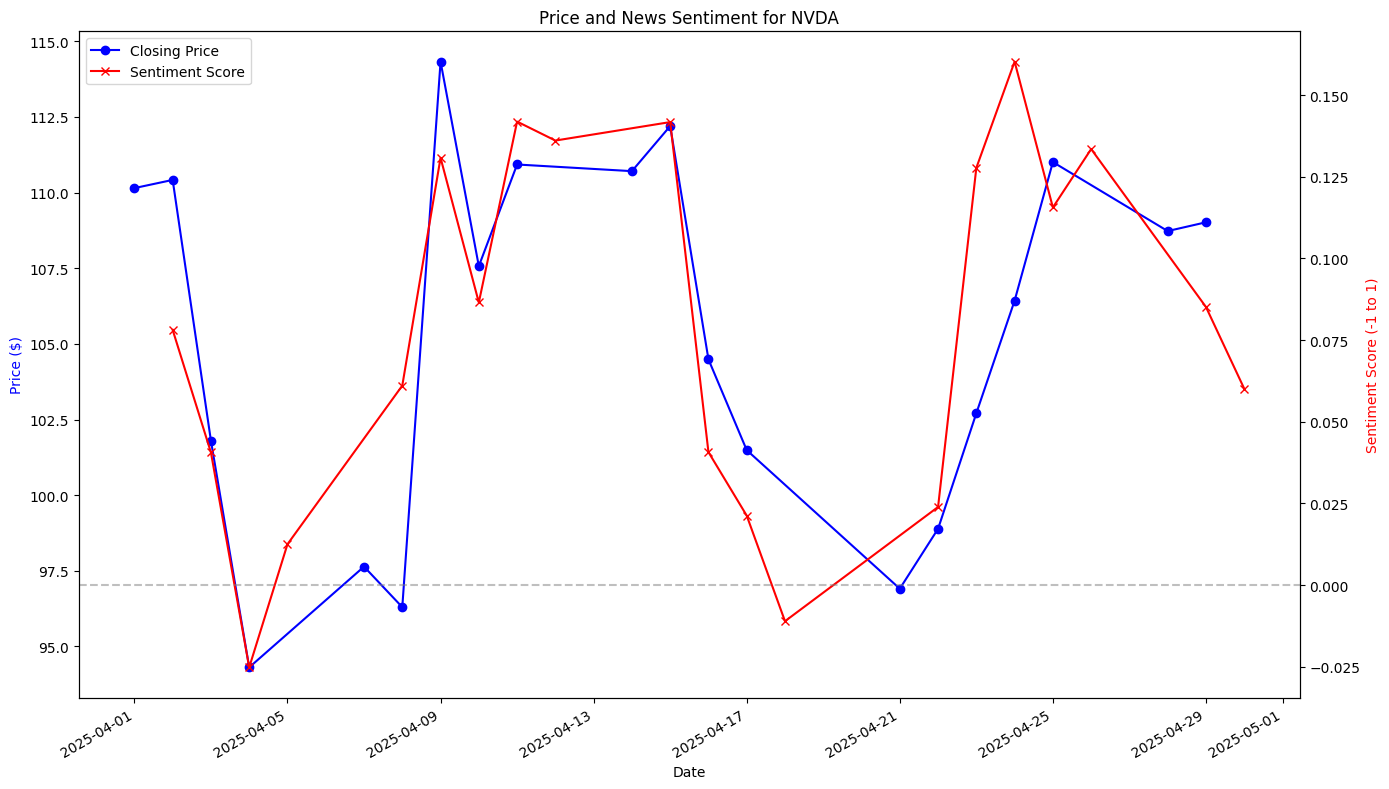

In [108]:
fig = plot_price_and_sentiment(sp500_prices, sentiment_df_shifted)
# plt.savefig('sp500_price_and_sentiment.png', dpi=300)
plt.show()

In [147]:
sentiment_df_shifted['date'] = pd.to_datetime(sentiment_df_shifted['date'])
daily_sentiment = sentiment_df_shifted.groupby(sentiment_df_shifted['date'].dt.date)['sentiment_score'].mean()
daily_sentiment.head(50)

,sentiment_score
date,
2025-04-02,0.078111
2025-04-03,0.040595
2025-04-04,-0.025186
2025-04-05,0.012507
2025-04-08,0.061058
2025-04-09,0.130786
2025-04-10,0.086504
2025-04-11,0.141861
2025-04-12,0.136059


In [148]:
# Solution for the specific structure you have

# Step 1: Access just the Close price with proper column selector
# Use tuple indexing to get the specific column
close_prices = sp500_prices[('Close')]

# Step 2: Now join with sentiment data (both have DatetimeIndex)
merged = close_prices.join(daily_sentiment, how='inner')

# Step 3: Calculate correlation
correlation = merged['NVDA'].corr(merged['sentiment_score'])
print(f"Pearson Correlation: {correlation:.4f}")
print(f"Number of data points: {len(merged)}")

Pearson Correlation: 0.7580
Number of data points: 15


## FinBERT Autoencoder
For the final fused model we need to train a finBERT autoencoder model. This is because the hidden-layer of the engineered stock features model have a 128-dimensional vector. We use an autoencoder to downsample to a latent dimension of 128. For use of the model the decoder will be removed and we will use just the encoder.

In [24]:
class FinBERTAutoencoder(nn.Module):
    def __init__(self, input_dim=768, latent_dim=128):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        # Decoder (for training)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def encode(self, x):
        # For inference only
        return self.encoder(x)

def extract_embeddings_from_df(df, embedding_column='finbert_embedding'):
    # Check if embedding column exists
    if embedding_column not in df.columns:
        raise ValueError(f"Column '{embedding_column}' not found in DataFrame.")

    # Extract embeddings - they should be stored as lists or arrays
    if isinstance(df[embedding_column].iloc[0], list):
        # If stored as list, convert to numpy array
        embeddings = np.array(df[embedding_column].tolist())
    else:
        # Try to convert from another format
        embeddings = np.stack(df[embedding_column].values)

    return embeddings

def train_autoencoder(model, embeddings, batch_size=64, epochs=50, lr=0.0001, test_size=0.2):
    # Split data into training and validation sets
    X_train, X_val = train_test_split(embeddings, test_size=test_size, random_state=42)
    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Training history
    history = {'train_loss': [], 'val_loss': []}

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs = inputs.to(device)

            _, reconstructed = model(inputs)
            loss = criterion(reconstructed, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs = inputs.to(device)
                _, reconstructed = model(inputs)
                loss = criterion(reconstructed, inputs)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        history['val_loss'].append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Save final model and history
    torch.save(model.state_dict(), 'final_model.pth')
    np.save('training_history.npy', history)

    print("Final model saved to: final_model.pth")

    return model, history

def plot_training_history(history, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='x')
    plt.title('Autoencoder Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add min val loss annotation
    min_val_epoch = np.argmin(history['val_loss'])
    min_val_loss = history['val_loss'][min_val_epoch]
    plt.annotate(f'Min Val Loss: {min_val_loss:.4f}',
                xy=(min_val_epoch, min_val_loss),
                xytext=(min_val_epoch+1, min_val_loss*1.2),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to {save_path}")

    plt.show()

def evaluate_reconstruction(model, embeddings, n_samples=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Convert to PyTorch tensor
    embeddings_tensor = torch.FloatTensor(embeddings).to(device)

    with torch.no_grad():
        # Get encoded (reduced) and reconstructed versions
        encoded, reconstructed = model(embeddings_tensor)

    # Convert back to numpy for calculations
    encoded_np = encoded.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()

    # Calculate reconstruction error (MSE)
    mse = ((embeddings - reconstructed_np) ** 2).mean()
    print(f"Reconstruction MSE: {mse:.4f}")

    # Calculate explained variance
    original_var = np.var(embeddings, axis=0).mean()
    error_var = np.var(embeddings - reconstructed_np, axis=0).mean()
    explained_var = 1 - (error_var / original_var)
    print(f"Explained variance: {explained_var:.4f}")

    # Calculate correlation between original and reconstructed
    correlations = []
    for i in range(min(100, len(embeddings))):  # Use up to 100 samples for speed
        corr = np.corrcoef(embeddings[i], reconstructed_np[i])[0, 1]
        correlations.append(corr)

    avg_correlation = np.mean(correlations)
    print(f"Average correlation: {avg_correlation:.4f}")

    # Print example reconstructions
    if n_samples > 0:
        print("\nSample reconstructions (first 10 dimensions):")
        for i in range(min(n_samples, len(embeddings))):
            print(f"\nSample {i+1}:")
            print(f"Original:      {embeddings[i][:10].round(3)}")
            print(f"Reconstructed: {reconstructed_np[i][:10].round(3)}")

    # Return evaluation metrics
    return {
        'mse': mse,
        'explained_variance': explained_var,
        'average_correlation': avg_correlation,
        'encoded_shape': encoded_np.shape,
        'reduced_dimensions': encoded_np.shape[1]
    }

In [7]:
def get_finbert_embeddings(headlines, model_name="yiyanghkust/finbert-tone", batch_size=64):
    # Load FinBERT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    print(f"Generating FinBERT embeddings for {len(headlines)} headlines using {device}...")

    # Generate embeddings in batches
    all_embeddings = []

    # Process headlines in batches to avoid memory issues
    for i in tqdm(range(0, len(headlines), batch_size)):
        batch = headlines[i:i+batch_size]

        # Tokenize headlines
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        )

        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Get CLS token embeddings from the last hidden state
        # CLS token is the first token [0] in the sequence
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeddings)

    # Concatenate all batches
    return np.vstack(all_embeddings)

def add_embeddings_to_df(df, headline_column='headline', model_name="yiyanghkust/finbert-tone", batch_size=32):
    # Create a copy of the dataframe
    result_df = df.copy()

    # Get list of headlines
    headlines = result_df[headline_column].tolist()

    # Generate embeddings
    embeddings = get_finbert_embeddings(headlines, model_name, batch_size)

    # Store embeddings as a new column
    # Since embeddings are vectors, we store them as lists
    result_df['finbert_embedding'] = embeddings.tolist()

    return result_df, embeddings

In [6]:
df = pd.read_csv("all_tickers_merged.csv")
df = df.iloc[:, :4]
df.head()

,date,headline,source,url
0,2025-04-24,Apple to strip secret robotics unit from AI ch...,Biztoc.com,https://biztoc.com/x/403a48b387f0661f
1,2025-04-24,Strong Earnings for Apple Could Precede a Tari...,Biztoc.com,https://biztoc.com/x/5088df66397d8540
2,2025-04-24,"On the Apple Watch's 10th anniversary, a look ...",Biztoc.com,https://biztoc.com/x/deb39e8c1fc28e22
3,2025-04-24,Fed officials argue for patience while gauging...,Biztoc.com,https://biztoc.com/x/5c7eb17314a3b0ac
4,2025-04-24,"Motorola Debuts $1,300 AI-Infused Razr Phone, ...",Biztoc.com,https://biztoc.com/x/7ea9eef503f36df7


In [9]:
# Get embeddings and add to dataframe
result_df, embeddings = add_embeddings_to_df(df)

Generating FinBERT embeddings for 4527 headlines using cuda...


100%|██████████| 142/142 [00:08<00:00, 16.34it/s]


In [21]:
result_df.head()

,date,headline,source,url,finbert_embedding
0,2025-04-24,Apple to strip secret robotics unit from AI ch...,Biztoc.com,https://biztoc.com/x/403a48b387f0661f,"[0.25456976890563965, -0.570956826210022, -1.7..."
1,2025-04-24,Strong Earnings for Apple Could Precede a Tari...,Biztoc.com,https://biztoc.com/x/5088df66397d8540,"[-0.03856136277318001, 0.24744392931461334, 0...."
2,2025-04-24,"On the Apple Watch's 10th anniversary, a look ...",Biztoc.com,https://biztoc.com/x/deb39e8c1fc28e22,"[-0.23466597497463226, -0.19376592338085175, -..."
3,2025-04-24,Fed officials argue for patience while gauging...,Biztoc.com,https://biztoc.com/x/5c7eb17314a3b0ac,"[0.15458959341049194, -0.4256336987018585, -1...."
4,2025-04-24,"Motorola Debuts $1,300 AI-Infused Razr Phone, ...",Biztoc.com,https://biztoc.com/x/7ea9eef503f36df7,"[-0.46427854895591736, -0.48961982131004333, -..."


Extracting embeddings from 'finbert_embedding' column...
Extracted embeddings shape: (4527, 768)
Initialized autoencoder: 768 → 128 dimensions

Training autoencoder...
Training set: (3621, 768), Validation set: (906, 768)
Using device: cuda


Epoch 1/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 744.35it/s]


Epoch 1/100: Train Loss = 0.7004, Val Loss = 0.5140


Epoch 2/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 703.93it/s]


Epoch 2/100: Train Loss = 0.4733, Val Loss = 0.4124


Epoch 3/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 591.26it/s]


Epoch 3/100: Train Loss = 0.3996, Val Loss = 0.3596


Epoch 4/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 694.62it/s]


Epoch 4/100: Train Loss = 0.3541, Val Loss = 0.3208


Epoch 5/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 751.03it/s]


Epoch 5/100: Train Loss = 0.3175, Val Loss = 0.2899


Epoch 6/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 733.75it/s]


Epoch 6/100: Train Loss = 0.2892, Val Loss = 0.2655


Epoch 7/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 723.92it/s]


Epoch 7/100: Train Loss = 0.2664, Val Loss = 0.2451


Epoch 8/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 676.93it/s]


Epoch 8/100: Train Loss = 0.2472, Val Loss = 0.2270


Epoch 9/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 712.03it/s]


Epoch 9/100: Train Loss = 0.2329, Val Loss = 0.2132


Epoch 10/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 725.06it/s]


Epoch 10/100: Train Loss = 0.2215, Val Loss = 0.2013


Epoch 11/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 701.16it/s]


Epoch 11/100: Train Loss = 0.2110, Val Loss = 0.1923


Epoch 12/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 726.14it/s]


Epoch 12/100: Train Loss = 0.2035, Val Loss = 0.1853


Epoch 13/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 714.44it/s]


Epoch 13/100: Train Loss = 0.1954, Val Loss = 0.1797


Epoch 14/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 458.48it/s]


Epoch 14/100: Train Loss = 0.1917, Val Loss = 0.1750


Epoch 15/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 491.23it/s]


Epoch 15/100: Train Loss = 0.1874, Val Loss = 0.1707


Epoch 16/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 525.57it/s]


Epoch 16/100: Train Loss = 0.1834, Val Loss = 0.1667


Epoch 17/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 430.91it/s]


Epoch 17/100: Train Loss = 0.1799, Val Loss = 0.1639


Epoch 18/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 465.04it/s]


Epoch 18/100: Train Loss = 0.1767, Val Loss = 0.1610


Epoch 19/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 529.41it/s]


Epoch 19/100: Train Loss = 0.1765, Val Loss = 0.1584


Epoch 20/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 564.45it/s]


Epoch 20/100: Train Loss = 0.1724, Val Loss = 0.1560


Epoch 21/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 563.28it/s]


Epoch 21/100: Train Loss = 0.1692, Val Loss = 0.1538


Epoch 22/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 443.24it/s]


Epoch 22/100: Train Loss = 0.1679, Val Loss = 0.1518


Epoch 23/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 458.03it/s]


Epoch 23/100: Train Loss = 0.1652, Val Loss = 0.1502


Epoch 24/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 703.05it/s]


Epoch 24/100: Train Loss = 0.1636, Val Loss = 0.1484


Epoch 25/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 749.36it/s]


Epoch 25/100: Train Loss = 0.1619, Val Loss = 0.1466


Epoch 26/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 439.33it/s]


Epoch 26/100: Train Loss = 0.1604, Val Loss = 0.1448


Epoch 27/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 651.15it/s]


Epoch 27/100: Train Loss = 0.1598, Val Loss = 0.1435


Epoch 28/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 711.25it/s]


Epoch 28/100: Train Loss = 0.1567, Val Loss = 0.1419


Epoch 29/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 686.61it/s]


Epoch 29/100: Train Loss = 0.1565, Val Loss = 0.1411


Epoch 30/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 724.24it/s]


Epoch 30/100: Train Loss = 0.1546, Val Loss = 0.1394


Epoch 31/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 749.53it/s]


Epoch 31/100: Train Loss = 0.1529, Val Loss = 0.1385


Epoch 32/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 661.71it/s]


Epoch 32/100: Train Loss = 0.1512, Val Loss = 0.1370


Epoch 33/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 732.33it/s]


Epoch 33/100: Train Loss = 0.1505, Val Loss = 0.1361


Epoch 34/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 736.03it/s]


Epoch 34/100: Train Loss = 0.1493, Val Loss = 0.1352


Epoch 35/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 740.08it/s]


Epoch 35/100: Train Loss = 0.1481, Val Loss = 0.1340


Epoch 36/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 689.83it/s]


Epoch 36/100: Train Loss = 0.1474, Val Loss = 0.1330


Epoch 37/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 695.57it/s]


Epoch 37/100: Train Loss = 0.1458, Val Loss = 0.1320


Epoch 38/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 749.58it/s]


Epoch 38/100: Train Loss = 0.1447, Val Loss = 0.1312


Epoch 39/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 614.12it/s]


Epoch 39/100: Train Loss = 0.1441, Val Loss = 0.1306


Epoch 40/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 749.07it/s]


Epoch 40/100: Train Loss = 0.1436, Val Loss = 0.1296


Epoch 41/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 610.47it/s]


Epoch 41/100: Train Loss = 0.1428, Val Loss = 0.1287


Epoch 42/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 738.23it/s]


Epoch 42/100: Train Loss = 0.1418, Val Loss = 0.1278


Epoch 43/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 693.46it/s]


Epoch 43/100: Train Loss = 0.1412, Val Loss = 0.1269


Epoch 44/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 735.92it/s]


Epoch 44/100: Train Loss = 0.1398, Val Loss = 0.1262


Epoch 45/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 681.88it/s]


Epoch 45/100: Train Loss = 0.1389, Val Loss = 0.1257


Epoch 46/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 725.24it/s]


Epoch 46/100: Train Loss = 0.1381, Val Loss = 0.1249


Epoch 47/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 714.39it/s]


Epoch 47/100: Train Loss = 0.1372, Val Loss = 0.1246


Epoch 48/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 727.35it/s]


Epoch 48/100: Train Loss = 0.1369, Val Loss = 0.1238


Epoch 49/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 715.21it/s]


Epoch 49/100: Train Loss = 0.1356, Val Loss = 0.1230


Epoch 50/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 702.49it/s]


Epoch 50/100: Train Loss = 0.1360, Val Loss = 0.1231


Epoch 51/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 704.62it/s]


Epoch 51/100: Train Loss = 0.1348, Val Loss = 0.1219


Epoch 52/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 590.23it/s]


Epoch 52/100: Train Loss = 0.1341, Val Loss = 0.1211


Epoch 53/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 673.33it/s]


Epoch 53/100: Train Loss = 0.1349, Val Loss = 0.1207


Epoch 54/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 736.47it/s]


Epoch 54/100: Train Loss = 0.1329, Val Loss = 0.1202


Epoch 55/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 707.50it/s]


Epoch 55/100: Train Loss = 0.1328, Val Loss = 0.1196


Epoch 56/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 722.47it/s]


Epoch 56/100: Train Loss = 0.1324, Val Loss = 0.1193


Epoch 57/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 712.80it/s]


Epoch 57/100: Train Loss = 0.1321, Val Loss = 0.1186


Epoch 58/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 605.29it/s]


Epoch 58/100: Train Loss = 0.1312, Val Loss = 0.1183


Epoch 59/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 691.82it/s]


Epoch 59/100: Train Loss = 0.1311, Val Loss = 0.1177


Epoch 60/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 710.06it/s]


Epoch 60/100: Train Loss = 0.1296, Val Loss = 0.1173


Epoch 61/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 729.94it/s]


Epoch 61/100: Train Loss = 0.1300, Val Loss = 0.1168


Epoch 62/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 708.36it/s]


Epoch 62/100: Train Loss = 0.1296, Val Loss = 0.1166


Epoch 63/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 728.57it/s]


Epoch 63/100: Train Loss = 0.1288, Val Loss = 0.1162


Epoch 64/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 708.79it/s]


Epoch 64/100: Train Loss = 0.1270, Val Loss = 0.1155


Epoch 65/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 437.38it/s]


Epoch 65/100: Train Loss = 0.1270, Val Loss = 0.1150


Epoch 66/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 477.32it/s]


Epoch 66/100: Train Loss = 0.1263, Val Loss = 0.1148


Epoch 67/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 475.26it/s]


Epoch 67/100: Train Loss = 0.1264, Val Loss = 0.1144


Epoch 68/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 318.89it/s]


Epoch 68/100: Train Loss = 0.1257, Val Loss = 0.1140


Epoch 69/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 423.28it/s]


Epoch 69/100: Train Loss = 0.1264, Val Loss = 0.1134


Epoch 70/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 492.28it/s]


Epoch 70/100: Train Loss = 0.1253, Val Loss = 0.1132


Epoch 71/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 493.36it/s]


Epoch 71/100: Train Loss = 0.1244, Val Loss = 0.1126


Epoch 72/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 493.61it/s]


Epoch 72/100: Train Loss = 0.1241, Val Loss = 0.1125


Epoch 73/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 437.17it/s]


Epoch 73/100: Train Loss = 0.1237, Val Loss = 0.1121


Epoch 74/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 476.55it/s]


Epoch 74/100: Train Loss = 0.1235, Val Loss = 0.1116


Epoch 75/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 721.63it/s]


Epoch 75/100: Train Loss = 0.1231, Val Loss = 0.1117


Epoch 76/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 709.38it/s]


Epoch 76/100: Train Loss = 0.1229, Val Loss = 0.1110


Epoch 77/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 709.84it/s]


Epoch 77/100: Train Loss = 0.1231, Val Loss = 0.1105


Epoch 78/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 699.25it/s]


Epoch 78/100: Train Loss = 0.1224, Val Loss = 0.1106


Epoch 79/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 598.39it/s]


Epoch 79/100: Train Loss = 0.1220, Val Loss = 0.1099


Epoch 80/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 723.15it/s]


Epoch 80/100: Train Loss = 0.1214, Val Loss = 0.1099


Epoch 81/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 652.03it/s]


Epoch 81/100: Train Loss = 0.1212, Val Loss = 0.1095


Epoch 82/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 721.36it/s]


Epoch 82/100: Train Loss = 0.1207, Val Loss = 0.1090


Epoch 83/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 434.41it/s]


Epoch 83/100: Train Loss = 0.1201, Val Loss = 0.1088


Epoch 84/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 630.84it/s]


Epoch 84/100: Train Loss = 0.1220, Val Loss = 0.1087


Epoch 85/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 677.89it/s]


Epoch 85/100: Train Loss = 0.1192, Val Loss = 0.1083


Epoch 86/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 699.13it/s]


Epoch 86/100: Train Loss = 0.1185, Val Loss = 0.1081


Epoch 87/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 729.17it/s]


Epoch 87/100: Train Loss = 0.1184, Val Loss = 0.1078


Epoch 88/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 723.41it/s]


Epoch 88/100: Train Loss = 0.1190, Val Loss = 0.1076


Epoch 89/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 692.57it/s]


Epoch 89/100: Train Loss = 0.1180, Val Loss = 0.1071


Epoch 90/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 664.48it/s]


Epoch 90/100: Train Loss = 0.1185, Val Loss = 0.1069


Epoch 91/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 716.51it/s]


Epoch 91/100: Train Loss = 0.1183, Val Loss = 0.1067


Epoch 92/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 673.10it/s]


Epoch 92/100: Train Loss = 0.1169, Val Loss = 0.1067


Epoch 93/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 733.12it/s]


Epoch 93/100: Train Loss = 0.1174, Val Loss = 0.1063


Epoch 94/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 741.70it/s]


Epoch 94/100: Train Loss = 0.1175, Val Loss = 0.1065


Epoch 95/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 720.52it/s]


Epoch 95/100: Train Loss = 0.1174, Val Loss = 0.1054


Epoch 96/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 666.71it/s]


Epoch 96/100: Train Loss = 0.1173, Val Loss = 0.1055


Epoch 97/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 693.87it/s]


Epoch 97/100: Train Loss = 0.1170, Val Loss = 0.1055


Epoch 98/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 650.89it/s]


Epoch 98/100: Train Loss = 0.1167, Val Loss = 0.1052


Epoch 99/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 698.95it/s]


Epoch 99/100: Train Loss = 0.1158, Val Loss = 0.1049


Epoch 100/100 - Validation: 100%|██████████| 15/15 [00:00<00:00, 738.73it/s]


Epoch 100/100: Train Loss = 0.1153, Val Loss = 0.1050
Final model saved to: final_model.pth
Training history plot saved to training_history.png


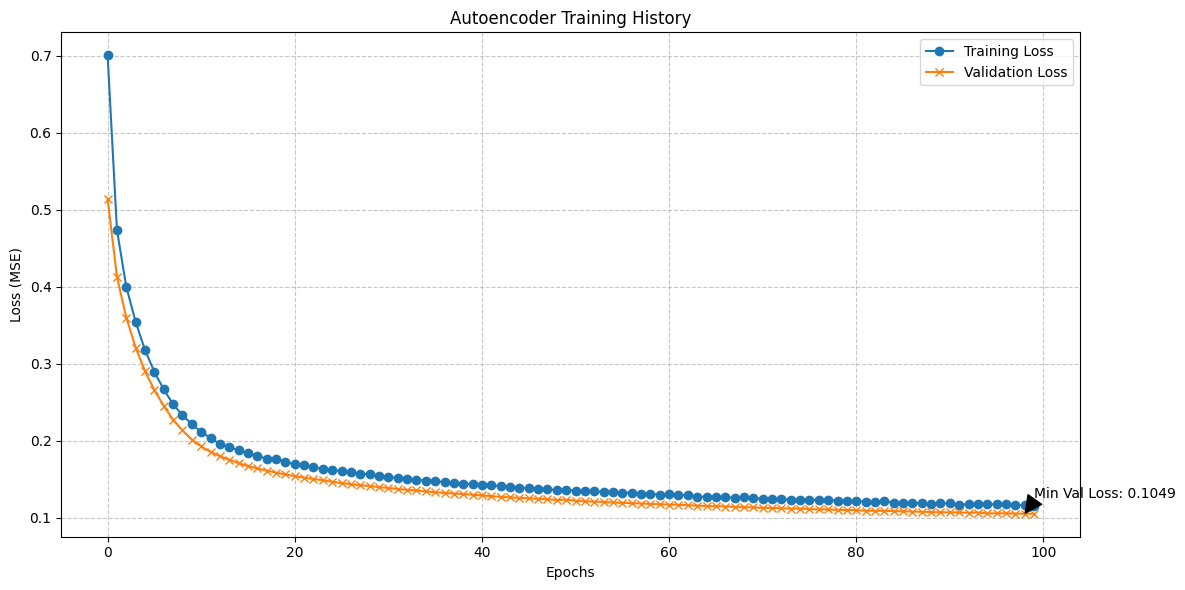

In [27]:
OUPUT_DIM = 128
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0001


# Extract embeddings from dataframe
print(f"Extracting embeddings from 'finbert_embedding' column...")
embeddings = extract_embeddings_from_df(result_df, 'finbert_embedding')
print(f"Extracted embeddings shape: {embeddings.shape}")

# Initialize model
input_dim = embeddings.shape[1]
model = FinBERTAutoencoder(input_dim=input_dim, latent_dim=OUPUT_DIM)
print(f"Initialized autoencoder: {input_dim} → {OUPUT_DIM} dimensions")

# Train model
print("\nTraining autoencoder...")
model, history = train_autoencoder(model, embeddings, lr=LEARNING_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS)

# Plot training history
history_plot_path = os.path.join('training_history.png')
plot_training_history(history, save_path=history_plot_path)

In [28]:
# Evaluate reconstruction
print("\nEvaluating reconstruction quality...")
eval_metrics = evaluate_reconstruction(model, embeddings)


Evaluating reconstruction quality...
Reconstruction MSE: 0.0906
Explained variance: 0.7823
Average correlation: 0.9430

Sample reconstructions (first 10 dimensions):

Sample 1:
Original:      [ 0.255 -0.571 -1.763  0.522  1.377 -0.942  0.127  0.528  0.436 -0.744]
Reconstructed: [-0.07  -0.733 -1.507  0.77   1.13  -1.027 -0.031  0.255  0.094 -0.36 ]

Sample 2:
Original:      [-0.039  0.247  0.537 -0.089 -0.156  1.436  0.168  1.88  -0.601  0.638]
Reconstructed: [-0.182 -0.235  0.28  -0.55   0.246  1.555  0.265  1.58  -0.552  0.496]

Sample 3:
Original:      [-0.235 -0.194 -0.642  0.086  0.476 -1.096 -0.312 -0.046 -0.941 -0.667]
Reconstructed: [ 0.045 -0.246 -0.865  0.667  0.398 -1.003 -0.279  0.094 -0.855 -0.35 ]

Sample 4:
Original:      [ 0.155 -0.426 -1.132  0.867  1.04   0.648  0.45   1.289 -0.157  0.091]
Reconstructed: [ 0.453 -0.15  -1.007  0.445  0.845  0.421 -0.018  1.103 -0.08   0.289]

Sample 5:
Original:      [-0.464 -0.49  -1.195  0.631  0.917 -0.793 -0.254  0.437 -1.145  0.